In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder,  FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle

file_path = 'data_cleaned.csv'

data = pd.read_csv(file_path)

X = data.drop('charges', axis=1)
y = data['charges']



In [49]:

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
# 80% pour train et 20% de test

print("Train set X", X_train.shape)
print("Train set Y", y_train.shape)
print("Test set X", X_test.shape)
print("Test set Y", y_test.shape)

Train set X (1136, 6)
Train set Y (1136,)
Test set X (201, 6)
Test set Y (201,)


In [51]:
def preprocess_data(data):
    # Initialiser l'encodeur de labels pour la conversion des données catégorielles
    label_encoder = LabelEncoder()

    # Convertir les colonnes 'sex' et 'smoker' en valeurs entières
    columns_to_encode = ['sex', 'smoker']
    for column in columns_to_encode:
        data[column] = label_encoder.fit_transform(data[column])  # Encodage des colonnes

    # Créer des variables binaires avec des noms explicites pour la colonne 'region'
    region_dummies_named = pd.get_dummies(data['region'], prefix='is', prefix_sep='_')

    # Concaténer ces variables binaires avec le DataFrame original
    data_with_named_dummies = pd.concat([data, region_dummies_named], axis=1)

    # Préparation de l'ensemble des caractéristiques (X) et de la variable cible (y)
    X = data_with_named_dummies.drop('charges', axis=1)  # Ensemble des caractéristiques
    y = data_with_named_dummies['charges']  # Variable cible

    # Création d'une colonne binaire pour le statut de fumeur
    X['smoker_binary'] = (X['smoker'] == 1).astype(int)

    # Définition des intervalles pour les catégories de BMI
    bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]  # Limites des catégories
    labels = ['underweight', 'normal weight', 'overweight', 'obesity class I', 'obesity class II', 'obesity class III']

    # Utilisation de pd.cut pour créer de nouvelles colonnes basées sur les catégories de BMI
    X['BMI_category'] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)

    # Utilisation de pd.get_dummies pour obtenir des colonnes binaires pour chaque catégorie de BMI
    BMI_dummies = pd.get_dummies(X['BMI_category'])

    # Ajout de ces colonnes binaires au DataFrame X
    X = pd.concat([X, BMI_dummies], axis=1)
   

    # Suppression des colonnes temporaires
    #X = X.drop(['smoker_binary', 'BMI_category'], axis=1)

    return X, y


# Définition de la fonction pour le prétraitement
def preprocess_data_func(data):
    X, y = preprocess_data(data)
    return X  # Retourne uniquement les caractéristiques (X)

# Utilisation de FunctionTransformer pour encapsuler la fonction
preprocess_transformer = FunctionTransformer(func=preprocess_data_func)

# Identifier les colonnes catégorielles et numériques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Créer le pipeline pour les caractéristiques numériques
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Créer le pipeline pour les caractéristiques catégorielles
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

# Combinez les pipelines en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols),
        ('categorical', categorical_pipeline, categorical_cols)
    ])

# Créez le pipeline final en ajoutant le modèle
LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(2)),
    ('preprocess_transform', preprocess_transformer),  # Utilisation de la transformation FunctionTransformer
    ('regression', LinearRegression())
])

Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(2)),
    ('preprocess_transform', preprocess_transformer),  # Utilisation de la transformation FunctionTransformer
    ('Lasso', Lasso())
])

ElasticNet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('preprocess_transform', preprocess_transformer), 
    ('poly', PolynomialFeatures(2)),
     # Utilisation de la transformation FunctionTransformer
    ('ElasticNet', ElasticNet())
])


ElasticNet_pipeline.fit(X_train,y_train)
ElasticNet_pipeline.score(X_test)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Recherche des meilleurs hyperparamètres de ElasticNet
Affichage du score, qui est le meilleur résultat

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

param_grid = { 
    'ElasticNet__alpha': [0.017], #np.arange(0.001, 0.0180, 0.001),
    'ElasticNet__l1_ratio': [0.78]#np.arange(0.78, 0.95, 0.01)
}

grid = GridSearchCV(ElasticNet_pipeline, param_grid, cv= 5)

grid.fit(X_train, y_train)
print(grid.best_params_)
model = grid.best_estimator_
print(model.score(X_test,y_test))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py", line 240, in transform
    return self._transform(X, func=self.func, kw_args=self.kw_args)
  File "/home/antoine/projets/ML/AssurePeopleUsa/venv/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py", line 312, in _transform
    return func(X, **(kw_args if kw_args else {}))
  File "/tmp/ipykernel_8610/1334788107.py", line 3, in preprocess_data_func
    X, y = preprocess_data(data)
  File "/tmp/ipykernel_8610/646570278.py", line 8, in preprocess_data
    data[column] = label_encoder.fit_transform(data[column])  # Encodage des colonnes
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


Export du model pour l'utiliser avec streamlit

In [ ]:
print(X_test)

      age     sex     bmi  children smoker     region
490    19  female  32.900         0     no  southwest
1206   36    male  33.400         2    yes  southwest
704    33  female  32.900         2     no  southwest
312    43    male  35.970         3    yes  southeast
57     18    male  31.680         2    yes  southeast
...   ...     ...     ...       ...    ...        ...
1336   61  female  29.070         0    yes  northwest
764    57  female  31.825         0     no  northwest
303    28  female  33.000         2     no  southeast
292    25    male  45.540         2    yes  southeast
582    32  female  23.650         1     no  southeast

[201 rows x 6 columns]


In [ ]:
# Sauvegarder le modèle dans un fichier .pkl
with open('exportModel.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('exportR2.pkl', 'wb') as file:
    pickle.dump(model.score(X_test, y_test), file)

Ce code trace une courbe d'apprentissage pour notre modèle ElasticNet. Les zones ombragées autour des lignes représentent l'intervalle de confiance des scores. Si les courbes convergent et que les scores de validation augmentent avec plus de données, c'est un bon signe. En revanche, si les courbes restent éloignées l'une de l'autre, cela peut indiquer un overfitting.

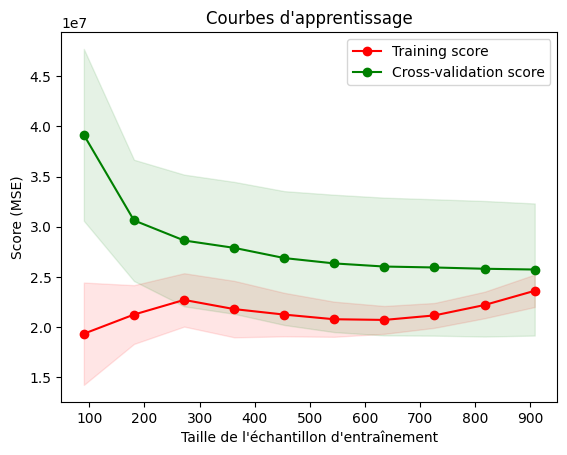

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Définir les intervalles pour la taille de l'échantillon d'entraînement
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculer les courbes d'apprentissage
train_sizes, train_scores, validation_scores = learning_curve(
    grid.best_estimator_, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='neg_mean_squared_error'
)

# Calculer la moyenne et l'écart-type des scores d'entraînement et de validation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Courbes d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score (MSE)")
plt.legend(loc="best")
plt.show()
